<div class="alert alert-info">
<h1>Cross-validation</h1>
<h4>Environmental Statistics 9</h4>
    
Ikedichi E. Azuh / C.F. Dormann
</div>

Cross-validation is a crucial technique in model evaluation and selection. In this session, we'll explore the principles of cross-validation and its applications in assessing model performance. Participants will learn how to implement different cross-validation methods, such as k-fold and leave-one-out cross-validation, to ensure robustness and generalizability of their predictive models.
  
There is two thing to learn today: 

  * How to implement cross-validation.
  * How to select the right size for blocks in block-cross-validation.
  * Maybe: Understand why different blocks yield different CV-error (tricky, that one).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from math import sqrt
from statsmodels.graphics.tsaplots import plot_pacf
from pygam import LinearGAM, s, f


## 1 Exercise 1: Cross-validation of a linear model

### 1.1 Fit body and brain weight as predictors to how many hours mammals are sleeping per day.

The data from R's faraway package, specifically the` mammalslee`p dataset utilized in the previous lecture, is available for reference. Take note of the self-reported residual standard error (= RMSE).

In [3]:
mammalsleep = pd.read_csv("mammalsleep.csv")
mammalsleep.describe()


,body,brain,nondream,dream,sleep,lifespan,gestation,predation,exposure,danger
count,62.000000,62.000000,48.000000,50.000000,58.000000,58.000000,58.000000,62.000000,62.000000,62.000000
mean,198.789984,283.134194,8.672917,1.972000,10.532759,19.877586,142.353448,2.870968,2.419355,2.612903
std,899.158011,930.278942,3.666452,1.442651,4.606760,18.206255,146.805039,1.476414,1.604792,1.441252
min,0.005000,0.140000,2.100000,0.000000,2.600000,2.000000,12.000000,1.000000,1.000000,1.000000
25%,0.600000,4.250000,6.250000,0.900000,8.050000,6.625000,35.750000,2.000000,1.000000,1.000000
50%,3.342500,17.250000,8.350000,1.800000,10.450000,15.100000,79.000000,3.000000,2.000000,2.000000
75%,48.202500,166.000000,11.000000,2.550000,13.200000,27.750000,207.500000,4.000000,4.000000,4.000000
max,6654.000000,5712.000000,17.900000,6.600000,19.900000,100.000000,645.000000,5.000000,5.000000,5.000000


In [4]:
model = sm.OLS.from_formula('sleep ~ np.log10(body) * np.log10(lifespan)', data=mammalsleep).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  sleep   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     10.45
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           1.90e-05
Time:                        11:51:31   Log-Likelihood:                -146.59
No. Observations:                  54   AIC:                             301.2
Df Residuals:                      50   BIC:                             309.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [5]:
n = 54 
p = model.df_model  # Number of predictors
residuals = model.resid
RMSE = np.sqrt(np.sum(residuals ** 2) / (n - 3 - 1))


print("RMSE:", RMSE)

RMSE: 3.79676561852267


In [27]:
# MSE
#mean_squared_error = np.mean((data['sleep'] - predicted) ** 2)

# RMSE
# rmse = sqrt(mean_squared_error)

# print("Root Mean Squared Error (RMSE):", rmse)


### 1.2 Run a leave-one-out cross-validation
How does the error in LOO compare to the error in the previously fitted model?

In [6]:
# first Remove NANs only with respect to ['lifespan', 'sleep']
np.random.seed(123)
ms = mammalsleep.dropna(subset=['lifespan', 'sleep'])
ms.reset_index(drop=True, inplace=True)

N = len(ms)
RMSEloo = [] #np.zeros(N)

for i in range(N):
    data_exclude_i = ms.drop(index=i)
    model = sm.OLS.from_formula('sleep ~ np.log10(body) * np.log10(lifespan)', data=data_exclude_i).fit()
    predscv = model.predict(ms.loc[i:i]).to_frame()
    rmse = sqrt(mean_squared_error([ms['sleep'].iloc[i]], predscv))
    RMSEloo.append(rmse)
    
print("Mean RMSE:", np.mean(RMSEloo))

Mean RMSE: 3.2393866117094423


In [7]:
# first Remove NANs only with respect to ['lifespan', 'sleep']
np.random.seed(123)
ms = mammalsleep.dropna(subset=['lifespan', 'sleep'])
ms.reset_index(drop=True, inplace=True)

N = len(ms)
RMSEloo2 = np.zeros(N)

for i in range(N):
    data_exclude_i = ms.drop(index=i)
    model = sm.OLS.from_formula('sleep ~ np.log10(body) * np.log10(lifespan)', data=data_exclude_i).fit()
    predscv = model.predict(ms.loc[i:i]).to_frame()
    RMSEloo2[i] = sqrt(mean_squared_error([ms['sleep'].iloc[i]], predscv))
    
print("Mean RMSE:", np.mean(RMSEloo2))


Mean RMSE: 3.2393866117094423


So the LOO-estimate for the error is even smaller than that of the self-reported error.

### 1.3 Run a 6-fold cross-validation
Since there are 54 data points (8 rows are incomplete, and we here don't want to conflate imputation and cross-validation), we can form 6 folds of 8 data poitns each. So simply omit the cases where we have no information on lifespan or sleep.

In [8]:
np.random.seed(122)
ms = mammalsleep.dropna(subset=['lifespan', 'sleep'])
ms.reset_index(drop=True, inplace=True)

folds = np.repeat(np.arange(1, 7), 8)  # similar to R's sample(rep(1:6, each=8))
np.random.shuffle(folds)  # Shuffling the folds


RMSE_6fold = np.zeros(6)

#fold_index = 0
for i in range(1, 7):
    train_indices = np.where(folds != i)[0]
    test_indices = np.where(folds == i)[0]

    train_data = ms.iloc[train_indices]
    test_data = ms.iloc[test_indices]

    formula = 'sleep ~ np.log10(body) * np.log10(lifespan)'
    model = sm.OLS.from_formula(formula, data=train_data)
    fitted_model = model.fit()

    X_test = test_data[['body', 'lifespan']]
    y_test = test_data['sleep']

    # Predicting on the test set
    pred = fitted_model.predict(X_test)
    RMSE_6fold[i - 1] = np.sqrt(mean_squared_error(y_test, pred))
    #RMSE6fold[fold_index] = np.sqrt(mean_squared_error(y_test, pred))
    #fold_index += 1

print("RMSE for each fold:", RMSE_6fold)
print("Mean RMSE (6-Fold Cross-Validation):", np.mean(RMSE_6fold))

RMSE for each fold: [2.4901426  6.05313279 3.37176414 4.68672695 2.28394596 4.05765046]
Mean RMSE (6-Fold Cross-Validation): 3.823893816579998


The 6-fold cross-validation yields an estimate very similar to the original linear model.

The problem is that we now have used only 6 splits of the data, and 6 is a really low number. Let's solve that in the next section.


### 1.4 Run a repeated sub-sampling validation
For example, 100 repetitions of a 70% train, 30% test split.
In this case, we can retain all the missing values, as they will be sometimes more in the train, sometimes more in the test, and that effect will wash out with the larger number of repetitions.

In [9]:
np.random.seed(123)
ms = mammalsleep.dropna(subset=['lifespan', 'sleep'])
ms.reset_index(drop=True, inplace=True)

reps = 100
trainProportion = 0.7

RMSE100fold = np.zeros(reps)

for k in range(reps):
    trainSize = int(trainProportion * len(ms))
    CVindex = np.random.permutation(len(ms)) # shuffle row numbers
    
    # Split data
    train_indices = CVindex[:trainSize] #select elements from (index 0) up to, but not including, the 'trainSize' index.
    test_indices = CVindex[trainSize:]
    
    # Fit a linear regression model
    model = sm.OLS.from_formula('sleep ~ np.log10(body) * np.log10(lifespan)',
                                data=ms.iloc[train_indices]).fit()
    predscv = model.predict(ms.iloc[test_indices])

    RMSE100fold[k] = sqrt(mean_squared_error(ms['sleep'].iloc[test_indices], predscv))

print("Mean RMSE (100-Fold Cross-Validation):", np.mean(RMSE100fold))
print("Standard Deviation of RMSE:", np.std(RMSE100fold))


Mean RMSE (100-Fold Cross-Validation): 3.9943484025399396
Standard Deviation of RMSE: 0.5194907952554335


This repeated split-based CV-approaches yield larger RMSE than the self-reporting linear model, which can be attributed to the substantially lower sample size when fitting the model. This difference becomes smaller as the sample size increases.


## 2 Cross-validation for time series
Time-series cross-validation has to overcome the problem of temporal autocorrelation. It is thus typically a two-step procedure. First, we quantify the range of temporal autocorrelation *in the raw response data*. Then we make blocks of something like twice the range of the autocorrelation, and then use them in a k-fold cross-validation.

The key problem arises for time series with strong periodicity. For example, predicting from April of one year to Aril the next year may much more accurate than to September in the same (or next) year. In such a case, we need to make the blocks much larger than the periodicity (e.g. 10 years), or much smaller (e.g. months).

### 2.1 Compute (partial) autocorrelation for the CO2 data
The data are in **locfit**. Deduce from the partial ACF what could be good block sizes. Then fit a GAM *without* autocorrelation structure (simply because it is much faster), a trend across years and with a cyclic spline for month. Compute for this baseline GAM the standard deviation of the residuals (equivalent to the RMSE of that model).


   year  month     co2
0  1959      1  315.42
1  1959      2  316.32
2  1959      3  316.49
3  1959      4  317.56
4  1959      5  318.13


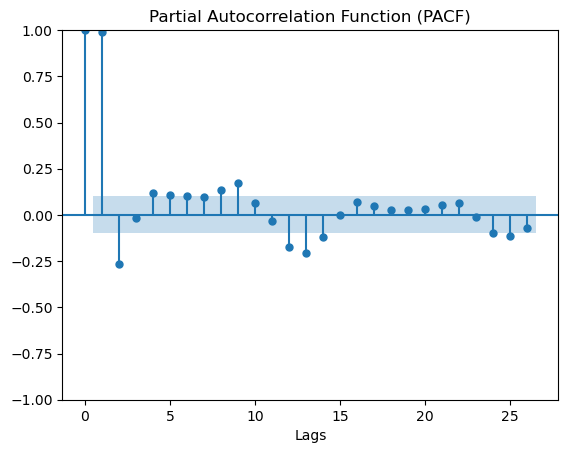

In [10]:
co2 = pd.read_csv('co2.csv')
print(co2.head())

plot_pacf(co2['co2'])
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.show()

This suggests a lag of 2 months (first a positive, then a negative correlation), and other lags at 9/10, 12/13 months. From this we could suggest block sizes of 4-8 month or more than 2 years.

In [11]:
X = co2[['year', 'month']].values
y = co2['co2'].values

fbaseline = LinearGAM(s(0) + s(1, n_splines=12)).fit(X, y)

print(fbaseline.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.6119
Link Function:                     IdentityLink Log Likelihood:                                 -1070.9155
Number of Samples:                          384 AIC:                                             2183.0548
                                                AICc:                                            2185.5133
                                                GCV:                                                0.1305
                                                Scale:                                              0.1185
                                                Pseudo R-Squared:                                   0.9992
Feature Function                  Lam

C:\Users\Ikedichi_Azuh\AppData\Local\Temp\ipykernel_13476\2545901427.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(fbaseline.summary())


In [12]:
residuals = y - fbaseline.predict(X)
residual_sd = np.std(residuals)

print("\n Standard Deviation of Residuals:", residual_sd)


 Standard Deviation of Residuals: 0.3353976128856606


In [13]:
RMSE = sqrt(mean_squared_error(y, fbaseline.predict(X)))

print("RMSE:", RMSE)

RMSE: 0.33539761288566083


### 2.2 Perform a monthly block-cross-validation
This is equivalent to a leave-one-out cross-validation!

In [14]:
RMSE1month = np.zeros(len(co2))

for i in range(len(co2)):
    X_exclude_i = np.delete(X, i, axis=0)
    y_exclude_i = np.delete(y, i)
    
    fcv = LinearGAM(s(0) + s(1, n_splines=12)).fit(X_exclude_i, y_exclude_i)
    pred = fcv.predict(X[i:i+1])
    RMSE1month[i] = sqrt(mean_squared_error(y[i:i+1], pred))

print("Mean RMSE (Leave-One-Out Cross-Validation):", np.mean(RMSE1month))


Mean RMSE (Leave-One-Out Cross-Validation): 0.27805270845130875


### 2.3 Perform a half-yearly block-cross-validation

In [15]:
co2['halfyear'] = np.where(co2['month'].isin(range(1, 7)), 0.25, 0.75) #ifelse(co2$month %in% 1:6, 0.25, 0.75)
co2['halfYears'] = co2['year'] + co2['halfyear']

blockIDs = co2['halfYears'].unique()

RMSE6month = np.zeros(len(blockIDs))

for i, blockID in enumerate(blockIDs):
    X_block = X[co2['halfYears'] != blockID]
    y_block = y[co2['halfYears'] != blockID]
    
    fcv = LinearGAM(s(0) + s(1, n_splines=12)).fit(X_block, y_block)
    X_pred = X[co2['halfYears'] == blockID]
    pred = fcv.predict(X_pred)

    RMSE6month[i] = sqrt(mean_squared_error(y[co2['halfYears'] == blockID], pred))

print("Mean RMSE (Half-Year Cross-Validation):", np.mean(RMSE6month))


Mean RMSE (Half-Year Cross-Validation): 0.3473218886742487


### 2.4 Perform a yearly block-cross-validation

In [16]:
years_unique = co2['year'].unique()

RMSE12month = np.zeros(len(years_unique))

for i, year in enumerate(years_unique):
    X_year = X[co2['year'] != year]
    y_year = y[co2['year'] != year]
    
    fcv = LinearGAM(s(0) + s(1, n_splines=12)).fit(X_year, y_year)
    X_pred = X[co2['year'] == year]
    pred = fcv.predict(X_pred)

    RMSE12month[i] = sqrt(mean_squared_error(y[co2['year'] == year], pred))

print("Mean RMSE (Yearly Cross-Validation):", np.mean(RMSE12month))


Mean RMSE (Yearly Cross-Validation): 0.39624376448649146


### 2.5 Perform a 5-yearly block-cross-validation
Hint: you can use the nifty trick of (i) subtracting 1954 from `co2$year` and (ii) then computing the integer remains of dividing by 5 (`%/% 5`), which will give you a vector from 1 to 7 for blocks of 5 years. (To look at the help for this function, type `?"%/%"`.)

In [17]:
years5 = (co2['year'] - 1954) // 5

blockIDs = np.unique(years5)
RMSE60month = np.zeros(len(blockIDs))

for i, blockID in enumerate(blockIDs):
    X_block = X[years5 != blockID]
    y_block = y[years5 != blockID]
    
    fcv = LinearGAM(s(0) + s(1, n_splines=12)).fit(X_block, y_block)
    X_pred = X[years5 == blockID]
    pred = fcv.predict(X_pred)
    RMSE60month[i] = sqrt(mean_squared_error(y[years5 == blockID], pred))

print("Mean RMSE (5-Year Block Cross-Validation):", np.mean(RMSE60month))


Mean RMSE (5-Year Block Cross-Validation): 0.6444179511515061


### 2.6 Compare the three resulting estimates of predictability
Plot RMSE as a function of 1 over the square root of training data sample size.


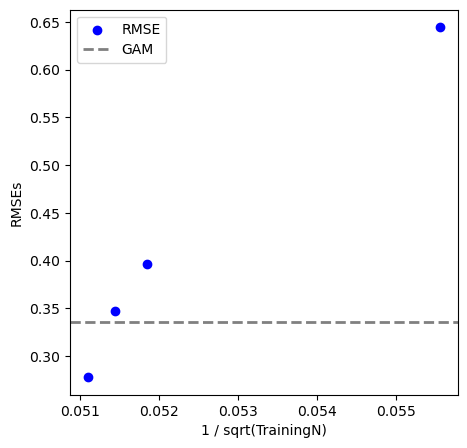

In [18]:
trainingN = [len(co2) - 1, len(co2) - 6, len(co2) - 12, len(co2) - 60]
RMSEs = [np.mean(RMSE1month), np.mean(RMSE6month), np.mean(RMSE12month), np.mean(RMSE60month)]

inv_sqrt_trainingN = [1 / np.sqrt(n) for n in trainingN]

plt.figure(figsize=(5,5))
plt.scatter(inv_sqrt_trainingN, RMSEs, marker='o', label='RMSE', color='blue')
plt.axhline(y=residual_sd, color='grey', linestyle='--', linewidth=2, label='GAM')
plt.xlabel('1 / sqrt(TrainingN)')
plt.ylabel('RMSEs')
plt.legend()
plt.show()


Note that we expect the error to increase *linearly* with 1 over the square root of sample size: $sem = \text{RMSE}= s/\sqrt{n}$ (i.e. a line through the origin with slope $s$, if we put 1/$\sqrt{n}$ on the x-axis). The deviation from such a linear relationship indicates ... that it is not the sample size alone that causes the increase in RMSE as the cross-validation blocks get larger (and training sample size thus smaller)!

We can compute the estimated underlying standard deviation by simply multiplying the square-root of training sample size onto the RMSE estimates. In principle, these values should be the same, if all cross-validation strategies were the same:

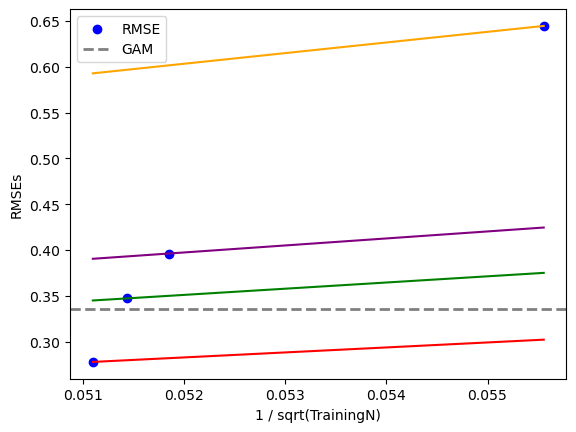

In [19]:

RMSE_sqrt_trainingN = [rmse * np.sqrt(n) for rmse, n in zip(RMSEs, trainingN)]


plt.scatter(inv_sqrt_trainingN, RMSEs, marker='o', label='RMSE', color='blue')
plt.axhline(y=residual_sd, color='grey', linestyle='--', linewidth=2, label='GAM')
plt.plot(inv_sqrt_trainingN, RMSE_sqrt_trainingN[0]*np.array(inv_sqrt_trainingN), color='red', label='')
plt.plot(inv_sqrt_trainingN, RMSE_sqrt_trainingN[1]*np.array(inv_sqrt_trainingN), color='green')
plt.plot(inv_sqrt_trainingN, RMSE_sqrt_trainingN[2]*np.array(inv_sqrt_trainingN), color='purple')
plt.plot(inv_sqrt_trainingN, RMSE_sqrt_trainingN[3]*np.array(inv_sqrt_trainingN), color='orange')
plt.xlabel('1 / sqrt(TrainingN)')
plt.ylabel('RMSEs')
plt.legend()
plt.show()


Instead we see that larger blocks, even when corrected for sample size effects, have larger uncertainty in their predictions.

In other words: extrapolating substantially from the data is much more uncertain than interpolation within. Indeed, it is the two corner-cases (first block and last block omitted) that have the highest RMSEs:

In [20]:
RMSE60month

array([0.36236237, 0.35099584, 0.50023479, 0.85834542, 0.43613471,
       0.57106919, 1.43178334])

And that seems to be a consistent pattern:

In [21]:
RMSE12month

array([0.37150295, 0.29164459, 0.22520361, 0.25990562, 0.26579023,
       0.32773631, 0.54266781, 0.35167643, 0.34924217, 0.21358024,
       0.19546078, 0.39771038, 0.38207961, 0.68924797, 0.94983415,
       0.23336313, 0.17681282, 0.4433755 , 0.29779233, 0.24190257,
       0.29263274, 0.34781074, 0.34927632, 0.45721626, 0.46311473,
       0.38565736, 0.30358763, 0.44033375, 0.55224722, 0.66391016,
       0.30237858, 0.91510576])

Thus, when autocorrelation cannot leak efficiently into the validation data, predictions are more realistically estimated as uncertain than when the block size is too small.

In [ ]:
# Bonus: For Binary, multi-response use AUC
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_dataset['Responce_variable'], predicted)
auc